## Opis zadatka 

Date su **dve datoteke** koje sadrže podatke o **pristupima predavanjima** održanim u organizaciji Matematičkog fakulteta na Webex platformi (zadatak predstavlja probni zadatak i podaci o pristupima nisu kompletni). Jedna datoteka je kompromitovana nekonzistentnim izmenama, potrebno je otkriti tu datoteku i ne koristiti je u analitici. **Zadatak** je za svaki sastanak, po svakom opisanom datumu, izračunati akumulativno broj prisutnih na sastanku. 

### Učitavanje podataka

Obe datoteke su u formatu zarezima odvojenih vrednosti. Za obradu podataka biće korišćeni **pandas**, **numpy**  i **matplotlib** moduli.

In [1]:
import pandas as pd 
import numpy as np

In [2]:
ucitaj = lambda datoteka: pd.read_csv(datoteka,
                                      parse_dates = ['JOIN_DATE','START_TIME','END_TIME'])

In [3]:
pristupi1 = ucitaj('WebexMeetings1.csv')
pristupi2 = ucitaj('WebexMeetings2.csv')

Oba skupa imaju **22549** vrste, a razlikuju se po broju atributa gde prvi skup sadrži dva atributa više. 

In [4]:
print(pristupi1.shape)
pristupi1.dtypes

(22549, 12)


MEETING_NUMBER             int64
MEETING_NAME              object
CONFERENCE_ID            float64
USER_NAME                 object
EMAIL                     object
LOCATION                  object
JOIN_DATE         datetime64[ns]
START_TIME        datetime64[ns]
END_TIME          datetime64[ns]
DURATION                   int64
OS                        object
BROWSER                   object
dtype: object

In [5]:
print(pristupi1.shape)
pristupi2.dtypes

(22549, 12)


MEETING_NUMBER             int64
MEETING_NAME              object
CONFERENCE_ID            float64
OS                        object
BROWSER                   object
LOCATION                  object
JOIN_DATE         datetime64[ns]
START_TIME        datetime64[ns]
END_TIME          datetime64[ns]
DURATION                   int64
dtype: object

Uvidom u podatke, uočava se da sledeći tipovi pridruženi atributima nisu odgovarajući:<br>
* **MEETING_NUMBER**: označen kao broj, međutim atribut označava nominalne vrednosti pa je tip promenjen u kategorički. <br>
* **CONFERENCE_ID**: konverzija izvršena na isti način kao sa MEETING NUMBER. <br>
* **JOIN_DATE, START_TIME, END_TIME**: izvršena konverzija u tip datuma (pri učitavanju podataka). <br>

In [6]:
def izmena_tipova(podaci):
    podaci['MEETING_NUMBER'] = podaci['MEETING_NUMBER'].astype("category")
    podaci['CONFERENCE_ID'] = podaci['CONFERENCE_ID'].astype("category")

In [7]:
izmena_tipova(pristupi1)
izmena_tipova(pristupi2)

### Jednakost podataka skupova

U jednom skupu podataka nedostaju dva atributa koja su prisutna u drugom, pa se za početak proverava da li su u pitanju isti skupovi podataka i da li ta eliminacija informacija predstavlja nekonzistentnu izmenu.

In [8]:
isti = True
for kolona in pristupi2.columns: 
    isti = isti and np.all(pristupi1[kolona] == pristupi2[kolona])

if isti:
    print('Skupovi sadrže iste podatke.')
else:
    print('Skupovi ne sadrže iste podatke.')

Skupovi sadrže iste podatke.


Ako se ovi skupovi uporede ne uzimajući u obzir kolone USER_NAME i EMAIL, vidi se da oni sadrže iste podatke. Dakle, nekonzistentnom izmenom se smatra brisanje korisnih informacija iz druog skupa podataka i u nastavku će biti korišćen samo kompletniji, prvi skup podataka. 

In [9]:
podaci = pristupi1

### Provera konzistentnosti podataka

Podaci bi na neki način trebalo da predstavljaju vremensku serije. Međutim, narušena je glavna pretpostavka vremenskih serija da je vreme jednoznačno i da predstavlja indeks. U ovim podacima postoje preklapanja kod svih atributa koji se tiču vremena. <br>
Svakako ima smisla proveriti pravilnosti pristupanja Webex sastancima sa aspekta vremena kako bi se uočila potencijalna odstupanja i nekonzistentnosti ukoliko postoje. <br>

Analize koje treba izvršiti:
1. Proveriti atribute **JOIN_DATE**, **START_TIME**, **END_TIME** kako bi se proverila konzistentnost.
2. Proveriti zavisnosti i konzistentnosti:
    * conference id --> meeting number
    * meeting number --> meeting name
    * email --> name 
    * duration = start time - end time

Pregledanjem lokacija pristupa sastancima, može se videti značajan broj zemalja izvan Balkana i to se može smatrati sumnjivim. Međutim, ručnim pregledanjem ovih podataka uočava se da su u pitanju različiti seminari na kojima ućestvuju stručnjaci iz različitih delova sveta, kao i pristupi naših državljana iz drugih država.
<br>
Ovo može biti korisno u analizi vremena održavanja razgovora, jer postoji dobar razlog za postojanje vremena koje odskače van okvira vremena održavanja predavanja. Ovi podaci pored predavanja obuhvataju i seminare i neformalne između osoba iz različitih delova sveta. 

In [10]:
podaci['LOCATION'].unique()

array(['Serbia', 'United Kingdom', 'Bosnia and Herzegovina', 'Portugal',
       'United States', 'Montenegro', 'Macedonia', 'Australia',
       'Switzerland', 'Italy', 'Brazil', 'Croatia', 'Egypt', 'Germany',
       'United Arab Emirates', 'Canada', 'France', 'Ukraine',
       'Russian Federation', 'Romania', 'Spain', 'Ireland', 'Morocco',
       'Bulgaria', 'Belgium', 'Korea', 'Saudi Arabia'], dtype=object)

Ne zaboravivši da se komunikacija odvija online i da nijedna aktivnost nije nemoguća u aspektu vremena, ipak se vrši provera u vremenskim odstupanjima radi evidencije nekonzistentnih podataka. 
Organizovanje razgovora na Webexu možemo očekivati najviše u vreme predavanja (najposećeniji sastanci) što označava da sastanci treba da počnu od 8h i da se završe do 21h uveče. Takvih zapisa ima oko 4000, pa je korišćen restriktivniji uslov, da počeci sastanka budu pre 6h, kako bi se dobijeni podaci lakše ručno pregledali. U podacima nije uočeno ništa sumnjivo.

In [11]:
from datetime import time

pre_6 = podaci[podaci['START_TIME'].apply(lambda x: x.time()) < time(hour=6, minute=0)]
posle_20 = podaci[podaci['END_TIME'].apply(lambda x: x.time()) > time(hour=21, minute=0)]

_ = pd.concat([posle_20, pre_6])

In [12]:
from matplotlib import pyplot as plt

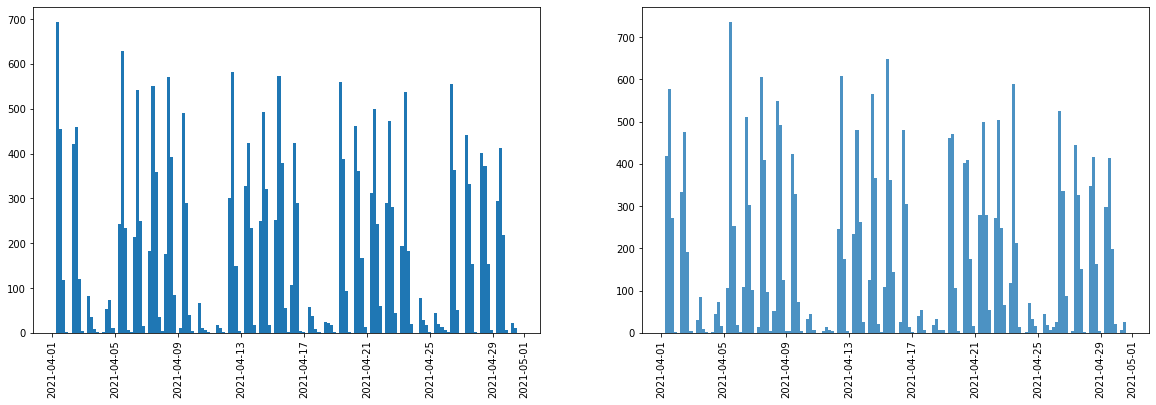

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))

ax1.hist(podaci['START_TIME'].sort_values(ascending=True),
         bins=150)
ax1.tick_params(axis='x', rotation=90 )

ax2.hist(podaci['END_TIME'].sort_values(ascending=True),
         bins=150,
         alpha=0.8)
ax2.tick_params(axis='x', rotation=90 )

plt.show()

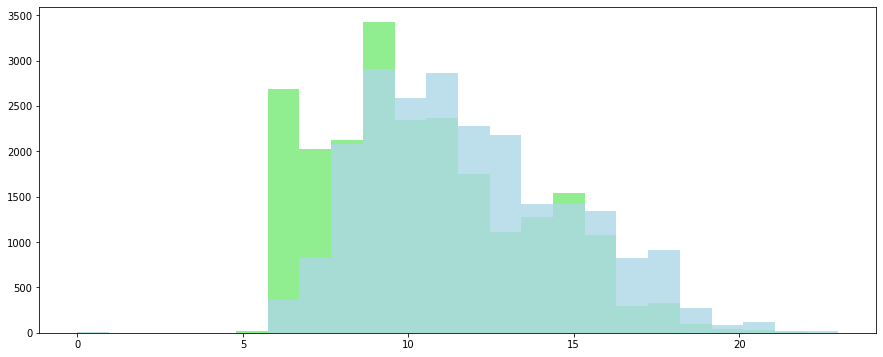

In [14]:
fig,ax = plt.subplots(1,1, figsize=(15,6))
ax.hist(podaci['START_TIME'].apply(lambda x: x.time().hour),
        bins=24,
        color='lightgreen')
ax.hist(podaci['END_TIME'].apply(lambda x: x.time().hour),
        bins=24,
        alpha=0.8,
        color='lightblue')

plt.show()

### Provera zavisnosti

Provera postojanja nekonzistentnih izmena u vidu razlike vrednosti atributa koji ti trebali da budu uslovljeni drugim.

In [15]:
def provera_zavisnosti(atr1, atr2):
    mapa = ({})
    
    for index, row in podaci[[atr1,atr2]].iterrows():
        kljuc = row[atr1]
        vrednost = row[atr2]
        
        if kljuc in mapa:
            if vrednost != mapa[kljuc]:
                print(f'Narusena zavisnosti')
                print(f'\tStara vrednost: {kljuc} -> {mapa[kljuc]}')
                print(f'\tNova vrednost: {kljuc} --> {vrednost}')
                mapa[kljuc] = vrednost
        else:
            mapa[kljuc] = vrednost

In [16]:
provera_zavisnosti('CONFERENCE_ID','MEETING_NUMBER')
provera_zavisnosti('MEETING_NUMBER','MEETING_NAME')

In [17]:
np.all(podaci['START_TIME'] < podaci['END_TIME'])

True

In [18]:
razlika = podaci['END_TIME'] - podaci['START_TIME']
razlika = razlika.apply(lambda x: np.ceil(x.seconds/60))

np.all((razlika == podaci['DURATION']) | (razlika == podaci['DURATION']-1))

True

### Zaključak
Nisu pronađene dodatne nekonzistentnosti.

### Rešenje zadatka
Za svaki sastanak, po svakom opisanom datumu, izračunati akumulativno broj prisutnih na sastanku. 

In [19]:
prisutnih_na_sastanku = podaci.groupby('JOIN_DATE')['CONFERENCE_ID'].value_counts() 
prisutnih_na_sastanku = pd.DataFrame(prisutnih_na_sastanku).set_axis(['NUMBER_OF_ATTENDEES'], axis=1)

prisutnih_na_sastanku.to_csv('prisutnih_na_sastanku.csv')